## 1. What is an A/B test ?

- The goal of running an **A/B test** is to evaluate if a change in a website or a product will lead to an improved performance in a certain metric.

- <u>Examples:</u>

1.   Changing the look of a single button on a web page or testing different layouts and headlines.
2.   Changing a multi-step process, which may have different steps involved in signing up a new user or processing the sale on an online marketplace.





## 2. Setting up the experiment and basic metrics of an A/B test:

- Let's suppose we are running an **A/B test** for  a hypothetical company that's trying to **increase the amount of users** that sign up for **a prenium account**. Let's first define some metrics that we are going to use all along the experiment:

- **<u>Baseline conversion rate (bcr):</u>** It's the current rate at which we sign up new users under the existing design.
- **<u>Lift/Desired lift:</u>** It's the increase/desired increase in sign ups that we would like to test.


## 3. Control group (A) and test group (B):

- The total number of users that participate in an A/B test **make up a small percentage of the total amount of users**. Users are randomly selected and assigned to either **a control group (A)** that contains the default design, or **a test group (B)** containing the new design we wanna test. **The sample size** that you decide on will determine how long you'll have to wait until you have collected enough data.

- For the project, we are going to use a **randomly generated dataset**, containing the results of an A/B test over two different designs of a web page. First, we are going to take **a bcr of 12%**, and then choose **a desired lift of 2%** in order to adopt the new web page design.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
import numpy as np

In [ ]:
num_a = 1000
num_b = 1000
bcr = 0.12
d_lift = 0.02

In [ ]:
def generate_data(num_a, num_b, p_a, p_b):
    data = []
    N = num_a + num_b

    # Initialize Bernouilli distributions
    group_bern = scs.bernoulli(num_a / N)
    A_bern = scs.bernoulli(p_a)
    B_bern = scs.bernoulli(p_b)

    for idx in range(N):
        row = {}
        row['group'] = group_bern.rvs()
        if row['group'] == 0:
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        data.append(row)

    df = pd.DataFrame(data)
    df['group'] = df['group'].apply(lambda x: "control" if x == 0 else "treatment")

    return df

In [ ]:
df = generate_data(num_a, num_b, bcr, bcr+d_lift)
df.head()

,group,converted
0,treatment,0
1,control,0
2,treatment,0
3,treatment,0
4,control,0


In [ ]:
df_summary = df.pivot_table(values='converted', index='group', aggfunc=np.sum)
df_summary['total'] = df.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
df_summary['rate'] = df.pivot_table(values='converted', index='group')
df_summary

,converted,total,rate
group,,,
control,106,954,0.111111
treatment,147,1046,0.140535


In [ ]:
a_converted = df_summary.loc['control']['converted']
b_converted = df_summary.loc['treatment']['converted']
a_total = df_summary.loc['control']['total']
b_total = df_summary.loc['treatment']['total']
p_a = df_summary.loc['control']['rate']
p_b = df_summary.loc['treatment']['rate']

## 4. Compare control and test groups:

- If we take the control or test group, we can notice that the **converted column** is just a series of independant **Bernouilli experiences** with a probability of success equal to the conversion rate of the group. If we take the control group, we'll have the statistical measures of this distribution as follows:

$$
\boxed{
  \ \ \ \ \ \ \mathop{\mathbb{E}}(X) = p \\
  \mathop{\mathbb{V}}(X) = p(1 - p)
  }
$$

- One way to have a visual confirmation about the difference between the control and the treatment group, is to plot both distributions. Since we have a series of bernouilli experiences, we can assume that the distributions follow a binomial distribution.


Text(0, 0.5, 'Probability')

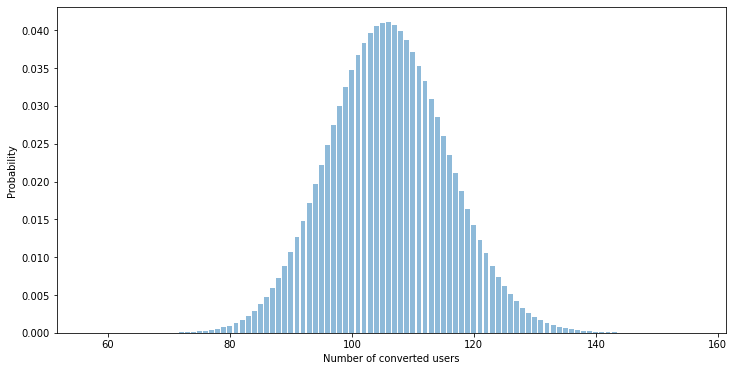

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(a_converted-49, a_converted+50, 100)
y = scs.binom(a_total, p_a).pmf(x)
ax.bar(x, y, alpha=0.5)
plt.xlabel('Number of converted users')
plt.ylabel('Probability')

Text(0, 0.5, 'Probability')

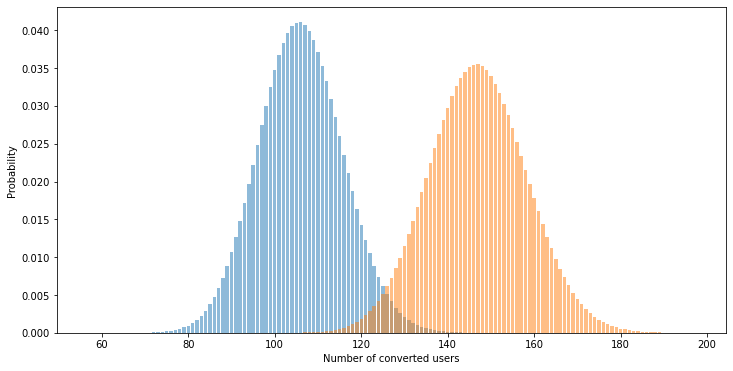

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(a_converted-49, a_converted+50, 100)
yA = scs.binom(a_total, p_a).pmf(xA)
ax.bar(xA, yA, alpha=0.5)
xB = np.linspace(b_converted-49, b_converted+50, 100)
yB = scs.binom(b_total, p_b).pmf(xB)
ax.bar(xB, yB, alpha=0.5)
plt.xlabel('Number of converted users')
plt.ylabel('Probability')

- By using **The central limit theorem**, we can approximate the distribution of the sample mean of converted column. If we consider $(X_i)_{1 \leq i \leq n}$ the random variables representing whether the user was converted or not, with a probability of success being equal to the conversion rate of the group. Then, we'll have the following:


$$
\boxed{
  S_{A} = \frac{X_1 + X_2 + ... + X_{n_A}}{n_A} \sim \mathcal{N}(\mu = p_A, \sigma = \frac{\sqrt{p_A(1 - p_A)}}{\sqrt{n_A}}) \\
  S_{B} = \frac{X_1 + X_2 + ... + X_{n_B}}{n_B} \sim \mathcal{N}(\mu = p_B, \sigma = \frac{\sqrt{p_B(1 - p_B)}}{\sqrt{n_B}})
}
$$

- Let's plot the distributions of $S_A$ and $S_B$:

In [ ]:
# Define the standard deviations for normal distributions Sa and Sb
std_a = np.sqrt(p_a * (1-p_a) / a_total)
std_b = np.sqrt(p_b * (1-p_b) / b_total)

Text(0, 0.5, 'PDF')

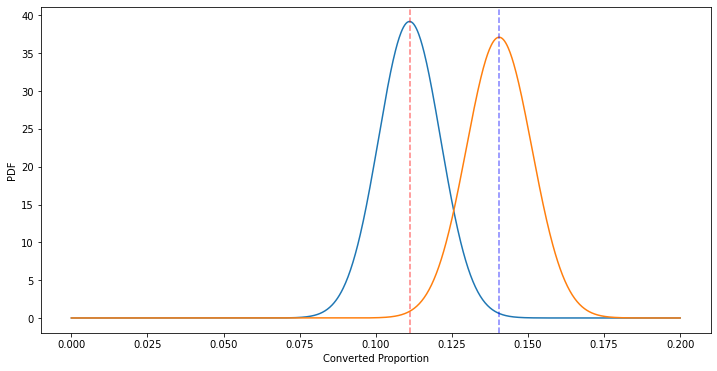

In [ ]:
# Plot distributions Sa and Sb
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(0, .2, 1000)
yA = scs.norm(p_a, std_a).pdf(x)
ax.plot(x, yA)
ax.axvline(x=p_a, c='red', alpha=0.5, linestyle='--')
yB = scs.norm(p_b, std_b).pdf(x)
ax.plot(x, yB)
ax.axvline(x=p_b, c='blue', alpha=0.5, linestyle='--')
plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

## 4. The minimum sample size required to have statistically significant results:

- First, let's re-define some statistical metrics used for hypothesis testing, that will help us understand the reason behind calculating a minimum required sample size:



1.   **<u>Type I error:</u>** is rejecting the null hypothesis (H0), when it should not be rejected. Type I error rate is also known as **$\alpha$**, **significance level** or **p-value**. We usually take a value of **0.05**.

2.   **<u>Type II error:</u>** is failing to reject the null hypothesis (H0), when it should be rejected. Type II error rate is also known as $\beta$.

2.   **<u>Statistical power:</u>** is rejecting the null hypothesis (H0), when it should be rejected. It's basically $1 - \beta$, and we usually take a statistical power of **0.8**.

- For our **A/B test** to be statistically significant, we need to have enough statistical power (e.g: greater than 0.8), which correlates with sample size used in the experiment for each group (A or B). Many statistical formulas exist to compute this minimum sample size, and we are gonna use this one:


$$\boxed{n = \frac{2\bar{p}(1 - \bar{p})(z_{\beta} - z_{\alpha / 2})^2}{(p_B - p_A)^2}}$$


- **$z_{\beta}$ :** The z-score that corresponds to parameter $\beta$.
- **$z_{\alpha / 2}$ :** The z-score that corresponds to the significance level $\alpha$.
- **$p_A, p_B$ :** are respectively the base conversion rate **(bcr)**, and the projected conversion rate, their difference is the desired lift **(d_lift)**.
- **$\bar{p}$ :** The pooled probability or average of $p_A$ and $p_B$. So, it can be expressed using the following formula:

$$\boxed{\bar{p} = \frac{p_A + (p_A + d_{lift})}{2}}$$







In [ ]:
def get_min_samples(p_a, p_b, power=0.8, alpha=0.05):
  # Define a standard normal distribution
  standard_norm = scs.norm(0, 1)

  # Cimpute z-scores
  z_beta = standard_norm.ppf(power)
  z_alpha = standard_norm.ppf(1-alpha/2)
  p_hat = (p_a + p_b) / 2
  return 2 * p_hat * (1 - p_hat) * (z_beta - z_alpha)**2 / (p_b - p_a)**2

print("The minimum number of samples required for the A/B test experiment: {}".format(int(get_min_samples(bcr, bcr + d_lift))))

The minimum number of samples required for the A/B test experiment: 707


## 5. Defining the null hypothesis (H0) and the alternative hypothesis (H1):

- First, let's define the random variable $S_D$, which is the difference between $S_A$ and $S_B$:

$$\boxed{S_D = S_B - S_A}$$

- We know that the expectation of $S_D$ can be written as:

$$
  \mathop{\mathbb{E}}(S_D) = \mathop{\mathbb{E}}(S_B) - \mathop{\mathbb{E}}(S_A) \\
  = p_B - p_A \\
$$

- and the variance of $S_D$ can be written in terms of the standard deviations of Bernouilli distributions of control and test group $s_A$, $s_B$ as: \\

$$
  \mathop{\mathbb{V}}(S_D) = \mathop{\mathbb{V}}(S_B) - \mathop{\mathbb{V}}(S_A) \\
  \\ = \frac{s_B^2}{n_B} - \frac{s_A^2}{n_A}
$$


$$
\boxed{
S_{d} \sim \mathcal{N}(\mu = p_B - p_A, \sigma = \sqrt{\frac{s_B^2}{n_B} - \frac{s_A^2}{n_A}}
}
$$




